# DATA 512 - Final Project Data Exploration
**Corey Christopherson**

This notebook is a record of the data exploration used for my study on the health of the Bainbridge Island aquifer system through an analysis of well log data.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import requests
import json
import os
import time

In [2]:
# Define paths
csvPath = r'C:/Users/chrico7/Documents/__Corey Christopherson/MS Data Science/Courses/HCDE 512/Final Project/Data/TextSearch_WellReports/'
outPath = r'C:/Users/chrico7/Documents/__Corey Christopherson/MS Data Science/Courses/HCDE 512/Final Project/Data/'

Well logs are recorded by the Washington State Department of Ecology and can be downloaded in csv form by using the Text Search Utility.

In order to get the most well logs in the fewest number of downloads, I only set the County field to 'Kistsap' as shown below

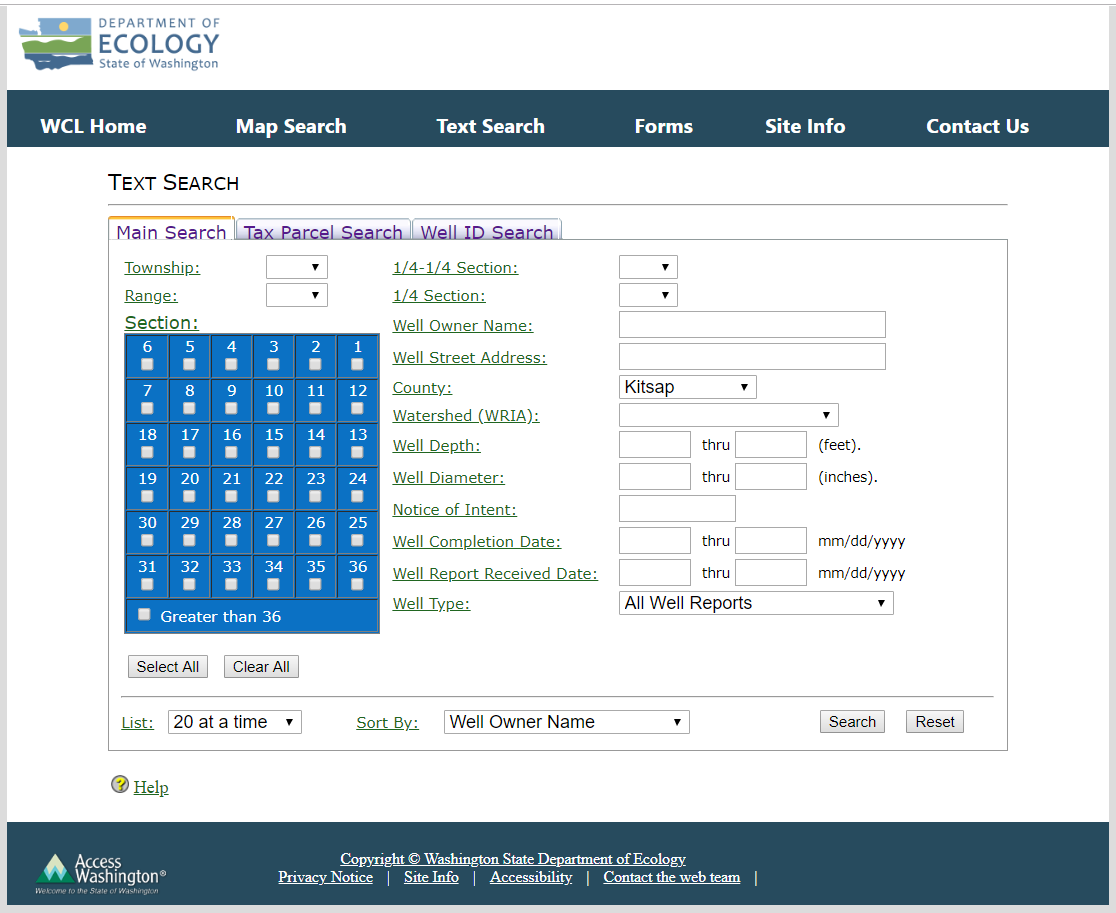

Clicking on the Search button opens the list of well logs and clicking on the Download Data link will download the raw data in csv format

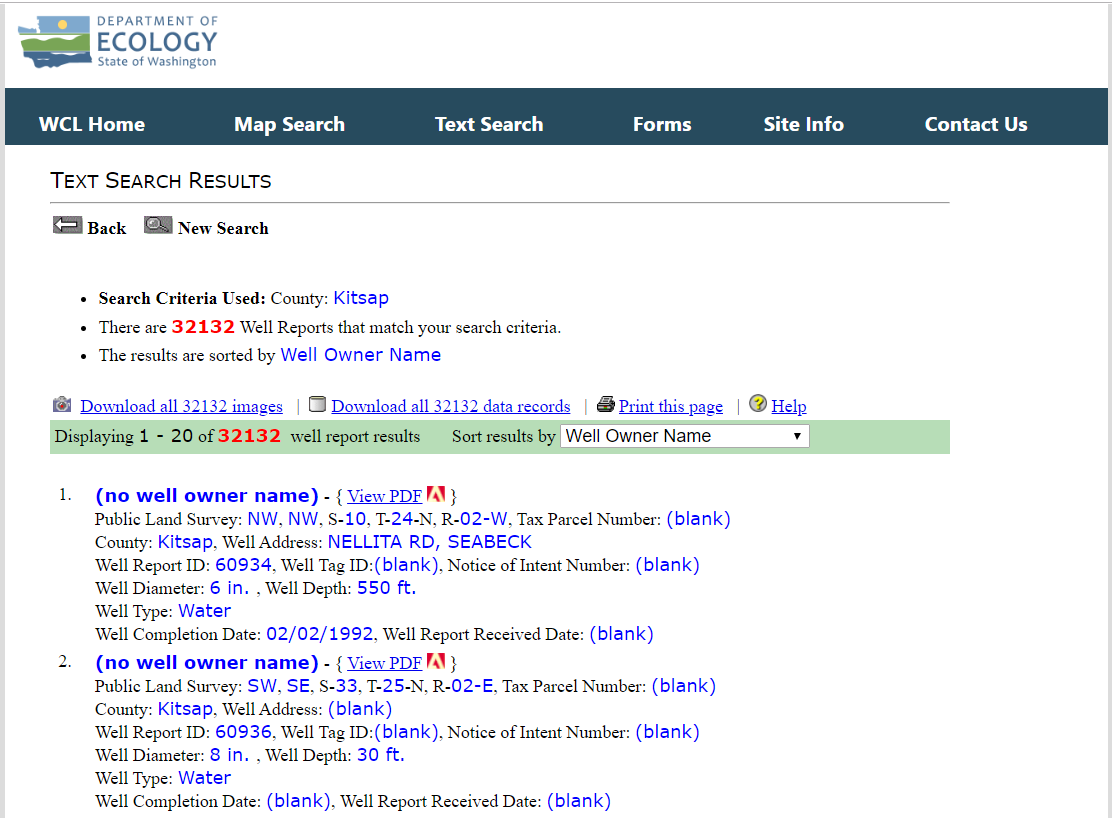

Once the data was downloaded, I read it into a Pandas dataframe

In [3]:
# Read in csv well logs file
well_logs_data_raw = pd.read_csv(r'{}ed0c1eae-6b80-41dc-9424-0ccc1aa157c5_11052019.csv'.format(csvPath))

Next, I explored the data to determine critical fields and any missing data

In [4]:
well_logs_data_raw.columns

Index(['well_log_id', 'well_tag_nr', 'nit_id_nr', 'well_depth_qt',
       'well_diameter_qt', 'well_owner_nm', 'township_nr', 'range_nr',
       'range_dir_cd', 'section_nr', 'qtr_section_cd', 'qtr_qtr_section_cd',
       'well_comp_dt', 'county_nm', 'well_type_cd', 'well_log_recv_dt',
       'tax_parcel_nr', 'ST_PLANE_XCOORD_NR', 'ST_PLANE_YCOORD_NR'],
      dtype='object')

In [178]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

Using the well_log_datadictionary.pdf file that is included in each download, I determined that I would need the following fields:

| Name | Description |
|:-------------------|:-----------------------------------------------------------------------------|
| well_log_id        | Unique well ID |
| well_depth_qt      | Depth of well in feet |
| well_diameter_qt   | Diameter of well in feet |
| well_comp_dt       | Well completion date |
| well_type_cd       | Well type code |
| ST_PLANE_XCOORD_NR | Well horizontal geographic coordinate value, WA State Plane Coordinate System |
| ST_PLANE_YCOORD_NR | Well vertical geographic coordinate value, WA State Plane Coordinate System |

Additionally, I only need records for wells with a well type code of W (Water)

In [5]:
# Drop redundant fields
keep_cols = ['well_log_id','well_depth_qt','well_diameter_qt','well_comp_dt','well_type_cd',
             'ST_PLANE_XCOORD_NR','ST_PLANE_YCOORD_NR']
well_logs_data = well_logs_data_raw[keep_cols].drop_duplicates()

# Drop records that do not have well_type_cd == W
well_logs_data = well_logs_data[well_logs_data['well_type_cd']=='W']

Next, I examined the resulting data frame and dropped records that had null values for the following fields

1. well_depth_qt
2. well_comp_dt
3. ST_PLANE_XCOORD_NR
4. ST_PLANE_YCOORD_NR

In [6]:
well_logs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13697 entries, 0 to 32098
Data columns (total 7 columns):
well_log_id           13697 non-null int64
well_depth_qt         13265 non-null float64
well_diameter_qt      13335 non-null float64
well_comp_dt          12145 non-null object
well_type_cd          13697 non-null object
ST_PLANE_XCOORD_NR    13563 non-null float64
ST_PLANE_YCOORD_NR    13563 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 856.1+ KB


In [7]:
# Drop records with NULL values
well_logs_data = well_logs_data[(~well_logs_data['well_depth_qt'].isnull())&
                                (~well_logs_data['well_comp_dt'].isnull())&
                                (~well_logs_data['ST_PLANE_XCOORD_NR'].isnull())&
                                (~well_logs_data['ST_PLANE_YCOORD_NR'].isnull())]

In [8]:
well_logs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11758 entries, 0 to 32098
Data columns (total 7 columns):
well_log_id           11758 non-null int64
well_depth_qt         11758 non-null float64
well_diameter_qt      11673 non-null float64
well_comp_dt          11758 non-null object
well_type_cd          11758 non-null object
ST_PLANE_XCOORD_NR    11758 non-null float64
ST_PLANE_YCOORD_NR    11758 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 734.9+ KB


Finally, I connected Tableau to the data soure to see how the well count changed over time

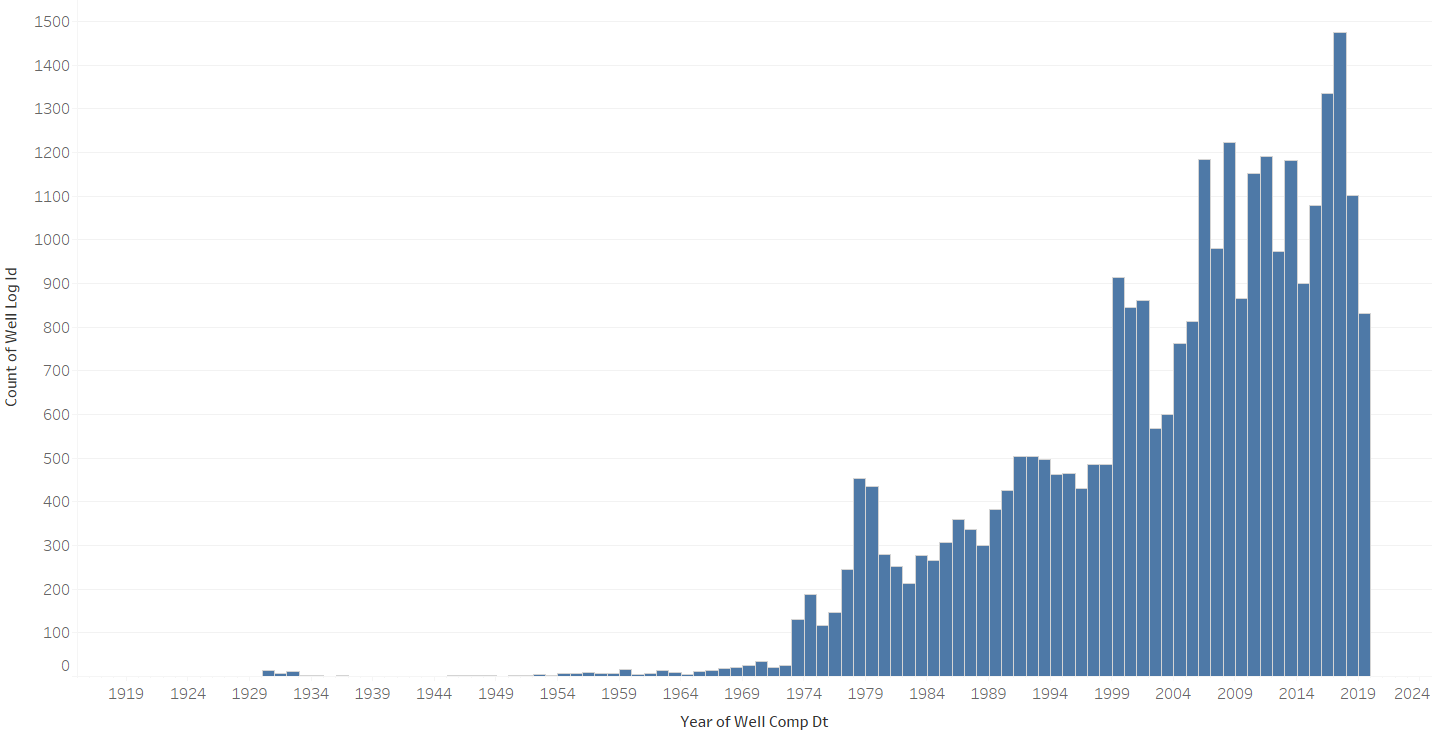

There is a clear issue with the well logs before 1973, so I am limiting my study to wells dug after 1973. Additionally, I am also removing the year 2019 since it is a partial year and could be biased by any seasonality.

In [9]:
# Convert field to datetime
well_logs_data.loc[:,'well_comp_dt'] = pd.to_datetime(well_logs_data['well_comp_dt'])
# Remove pre-1973 and post 2018 records
well_logs_data = well_logs_data[(well_logs_data['well_comp_dt'] >= '1973-1-1')&
                                (well_logs_data['well_comp_dt'] <= '2018-12-31')].reset_index(drop=True)
# Convert ST Plane coordinates to integers
well_logs_data.loc[:,['ST_PLANE_XCOORD_NR','ST_PLANE_YCOORD_NR']] = well_logs_data[['ST_PLANE_XCOORD_NR',
                                                                                    'ST_PLANE_YCOORD_NR']].astype(int)

In [10]:
well_logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11338 entries, 0 to 11337
Data columns (total 7 columns):
well_log_id           11338 non-null int64
well_depth_qt         11338 non-null float64
well_diameter_qt      11274 non-null float64
well_comp_dt          11338 non-null datetime64[ns]
well_type_cd          11338 non-null object
ST_PLANE_XCOORD_NR    11338 non-null int32
ST_PLANE_YCOORD_NR    11338 non-null int32
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(1)
memory usage: 531.6+ KB


Since I am planning to map the location of each well, I need to convert the WA State Plane Coordinate System to traditional lat-long coordinates. To do this conversion I used the NGS Coordinate Conversion and Transformation Tool (NCAT) API from the National Oceaniac and Atmospheric Administration (NOAA)

In [11]:
unique_st_vals = well_logs_data[['ST_PLANE_XCOORD_NR','ST_PLANE_YCOORD_NR']].drop_duplicates()

In [21]:
# Read in lat-long data
#
# Define base NCAT webservice URL
ncat_url = (r'https://geodesy.noaa.gov/api/ncat/spc?spcZone=4602&inDatum=nad83(2011)&outDatum=nad83(2011)&' + 
            'northing={}&easting={}&units=usft')
# Define NCAT cols to keep
lat_long_cols = ['well_log_id','srcLat','srcLon']

# Check if file exists and read it in if previously generated
if os.path.isfile('{}well_data_ncat_lat_long.csv'.format(outPath)):
    print('File already exists')
    # Read in previously generated file
    well_logs_data_loc = pd.read_csv(r'{}well_data_ncat_lat_long.csv'.format(outPath),low_memory=False)

# Pull lat-long from NCAT webservices for unique values
elif (unique_st_vals.shape[0] < len(well_logs_data['well_log_id'])):
    print('NCAT API Pull - Unique ST Coordinates')
    # Generate unique ST_PLANE fields
    unique_st_vals = well_logs_data[['ST_PLANE_XCOORD_NR','ST_PLANE_YCOORD_NR']].drop_duplicates()
    # Iterate through ST_PLANE values and get the lat-long for each
    start = time.time()
    unique_coords_data_loc = pd.DataFrame()
    unique_coords_bad = []
    for i in range(unique_st_vals.shape[0]):
        try:
            # extract x and y coordinates
            x_coord = unique_st_vals.loc[i,'ST_PLANE_XCOORD_NR']
            y_coord = unique_st_vals.loc[i,'ST_PLANE_YCOORD_NR']
            # define webservice urls
            temp_url = ncat_url.format(y_coord,x_coord)
            # pull data from webservice
            temp_request = requests.get(temp_url)
            temp_response = temp_request.json()
            # make data frame
            temp_df = pd.io.json.json_normalize(temp_response)
            # trim data frame
            temp_df = temp_df[lat_long_cols]
            # add data to main frame
            unique_coord_data_loc = unique_coord_data_loc.append(temp_df, ignore_index=True, sort=False)
        except:
            print('Error: unique_coord= {} {}'.format(x_coord, y_coord))
            unique_coords_bad.append(well)
    # Add lat-long data to frame
    well_logs_data_loc = pd.merge(well_logs_data, unique_coords_data_loc,
                                  how='left', on=['ST_PLANE_XCOORD_NR','ST_PLANE_YCOORD_NR'])
    # Convert well_log_id to integer
    well_logs_data_loc.loc[:,'well_log_id'] = well_logs_data_loc['well_log_id'].astype(int)
    # Write lat-long data to csv file for future reference
    well_logs_data_loc.to_csv('{}ncat_lat_long.csv'.format(outPath),header=True,index=False)
    print(time.time() - start)

# Iterate through well_log_ids and get the lat-long for each well
else:
    print('NCAT API Pull - Unique well_log_ids')
    start = time.time()
    well_logs_data_loc = pd.DataFrame()
    well_logs_bad = []
    for i in range(len(well_logs_data['well_log_id'])):
        try:
            # extract well log id
            well =  well_logs_data.loc[i,'well_log_id']
            # extract x and y coordinates
            x_coord = well_logs_data.loc[i,'ST_PLANE_XCOORD_NR']
            y_coord = well_logs_data.loc[i,'ST_PLANE_YCOORD_NR']
            # define webservice urls
            temp_url = ncat_url.format(y_coord,x_coord)
            # pull data from webservice
            temp_request = requests.get(temp_url)
            temp_response = temp_request.json()
            # make data frame
            temp_df = pd.io.json.json_normalize(temp_response)
            # trim data frame
            temp_df.loc[:,'well_log_id'] = well
            temp_df = temp_df[lat_long_cols]
            # add data to main frame
            well_logs_data_loc = well_logs_data_loc.append(temp_df, ignore_index=True, sort=False)
        except:
            print('Error: well_log_id={}'.format(well))
            well_logs_bad.append(well)
    # Convert well_log_id to integer
    well_logs_data_loc.loc[:,'well_log_id'] = well_logs_data_loc['well_log_id'].astype(int)
    # Write lat-long data to csv file for future reference
    well_logs_data_loc.to_csv('{}well_data_ncat_lat_long.csv'.format(outPath),header=True,index=False)
    print(time.time() - start)

File already exists


Recorded Data Pulls
1. Unique well_ids
   Error: well_log_id=61250  
   Error: well_log_id=66263  
   Error: well_log_id=102046  
   Error: well_log_id=102680  
   Error: well_log_id=103723  
   Error: well_log_id=105768  
   Error: well_log_id=107926  
   Error: well_log_id=247740  
   Error: well_log_id=695447  
   12402.281774044037

Now I can add the new lat-long data to the well_logs_data frame

In [22]:
well_logs_data.head(2)

,well_log_id,well_depth_qt,well_diameter_qt,well_comp_dt,well_type_cd,ST_PLANE_XCOORD_NR,ST_PLANE_YCOORD_NR
0,44457,198.0,6.0,1990-11-16,W,1056485,797894
1,46137,180.0,6.0,1988-07-15,W,1087187,767434


In [23]:
well_logs_data_loc.head(2)

,well_log_id,srcLat,srcLon
0,44457.0,47.497237,-122.862413
1,46137.0,47.416221,-122.734779


In [24]:
# Add lat-long to well_logs_data
well_logs_data2 = pd.merge(well_logs_data, well_logs_data_loc,how='left',on='well_log_id')

I can display the non-null counts for each field and confirm that every well_log_id was matched to a srcLat and srcLon.

In [25]:
well_logs_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11338 entries, 0 to 11337
Data columns (total 9 columns):
well_log_id           11338 non-null int64
well_depth_qt         11338 non-null float64
well_diameter_qt      11274 non-null float64
well_comp_dt          11338 non-null datetime64[ns]
well_type_cd          11338 non-null object
ST_PLANE_XCOORD_NR    11338 non-null int32
ST_PLANE_YCOORD_NR    11338 non-null int32
srcLat                11329 non-null float64
srcLon                11329 non-null float64
dtypes: datetime64[ns](1), float64(4), int32(2), int64(1), object(1)
memory usage: 797.2+ KB


As expected, every well was correctly matched except for the 9 entries that did not get data back from the NCAT webservices.

Now that it's possible to map these wells, I can filter out well logs that are not on Bainbridge Island. To accomplish this, I output the data to a csv for mapping in Tableau. 

In [26]:
# Check if file exists and write it to a file if not previously generated
if os.path.isfile('{}well_data_lat_long_kitsap_county.csv'.format(outPath)):
    print('File already exists')
else:
    # Output well_logs_data2
    well_logs_data2.to_csv('{}well_data_lat_long_kitsap_county.csv'.format(outPath),header=True,index=False)

File already exists


The mapped data looked like this

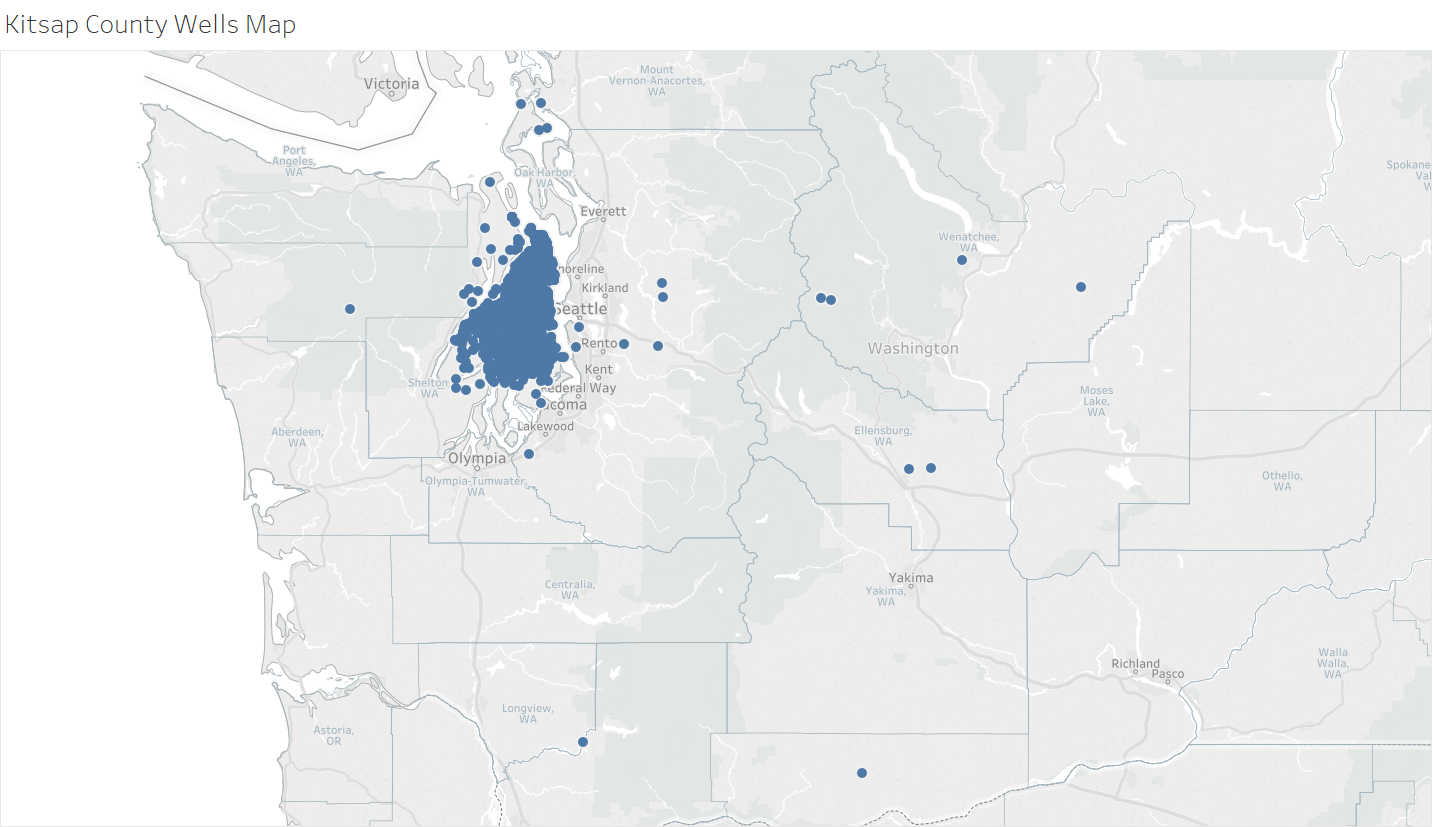

We can see that many wells have been located outside of Kitsap County. I picked a few examples at random and looked them up in the Washington Department of Ecology mapping tool to double check the accuracy of lat longs from the NCAT webservices. I confirmed that the wells are corrently located.

However, note that the location of the wells is not too accurate and has been snapped to a Township, Range, Section grid as shown below

Washington DOE Map Viewer

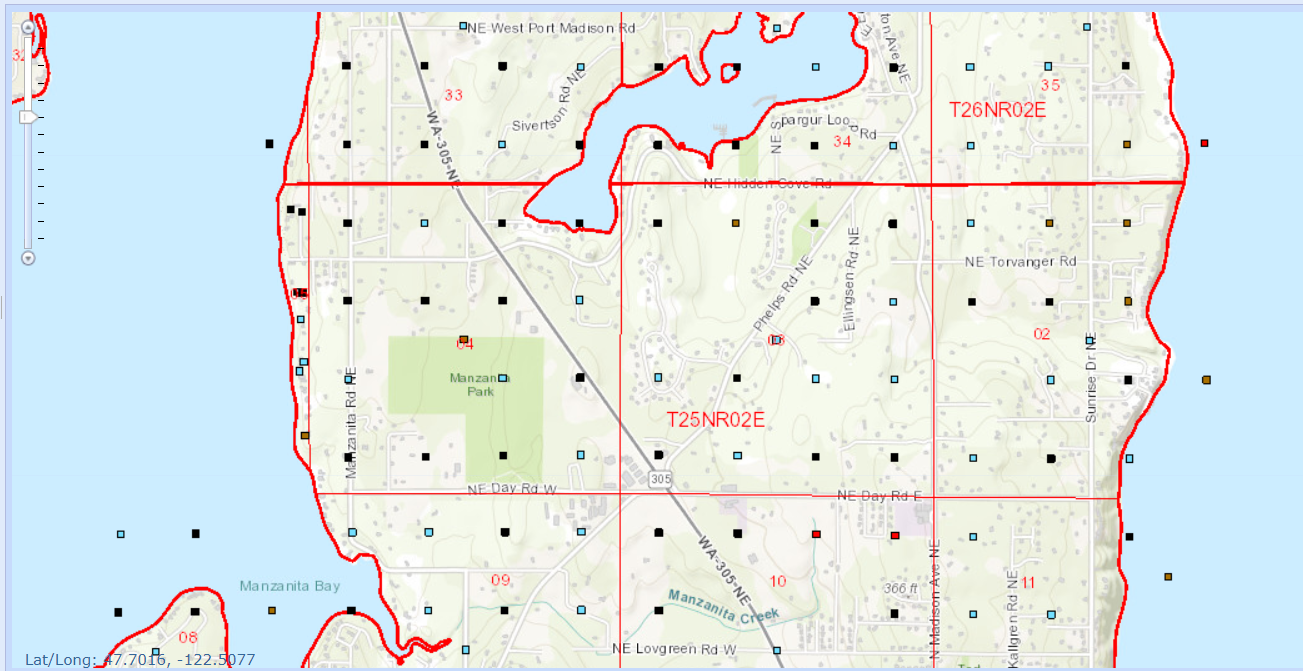

Tableau Map View

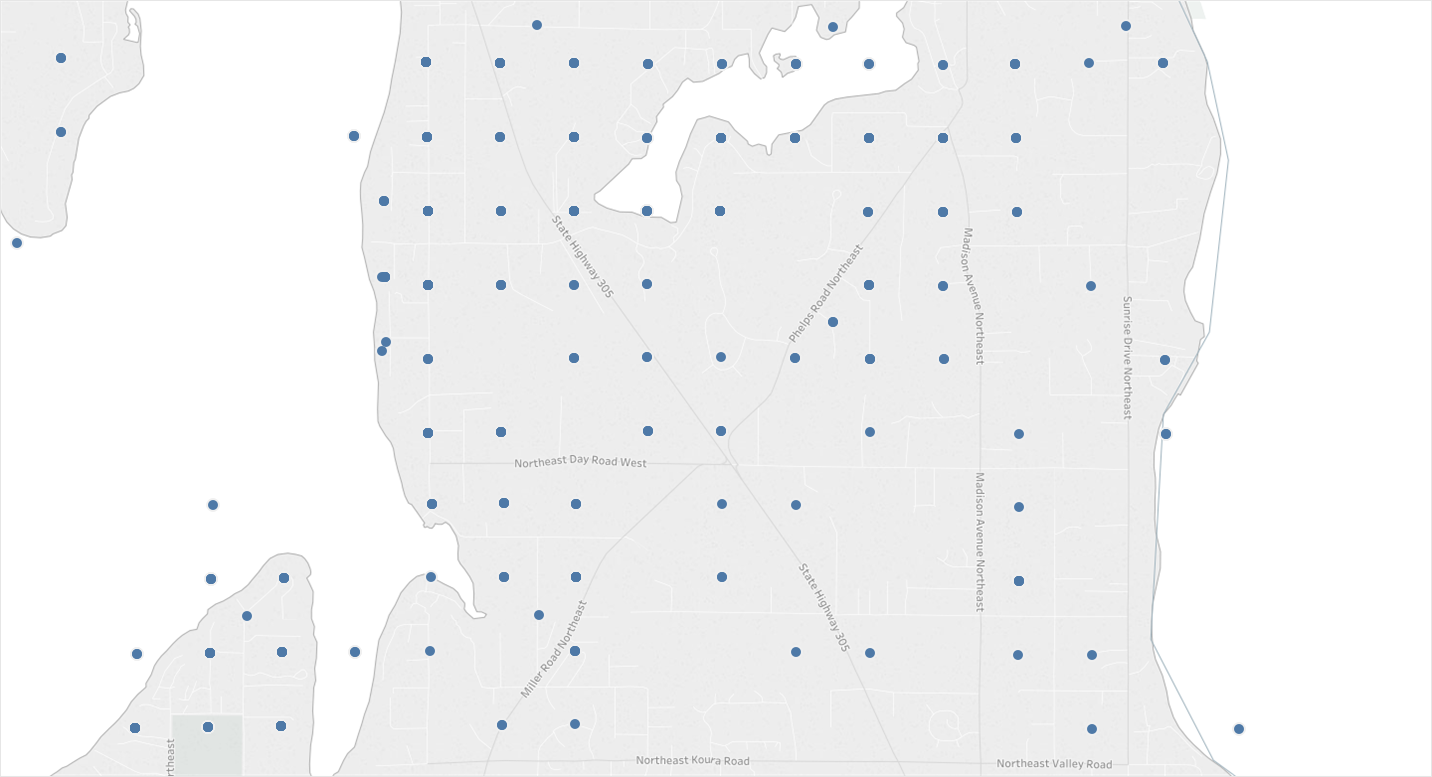

Because so many of the wells share the same ST Plane Coordinates, we can drastically reduce the number of queries to the NCAT webservices API by only pulling lat-longs for the unique locations instead of for each well log ID. The dimension of these two approaches are shown below

In [27]:
print(str(len(well_logs_data2['well_log_id'])) + ' unique well log IDs')
print(str(unique_st_vals.shape[0]) + ' unique ST Plane Coordinates')

11338 unique well log IDs
3595 unique ST Plane Coordinates


With this finding, I went back to the code block that pulls the lat-long data and added in logic to check and see if the lat-long file already exists (previously generated or downlaoded) and if the number of unique ST Plane Coordinates is less than the number of unique well log IDs. This allows for a much faster execution of the code.

Now that I've confirmed the well logs data is being correctly geolocated, I need to filter the data to only include wells located on Bainbridge Island. I accomplished this by manually selecting the Bainbridge wells from the Tableau map above and downloading the data into the well_data_lat_long_bainbridge_island.csv file. I can then read this csv into the workbook for further processing 

In [28]:
# Read in manually filtered Bainbridge Island wells data
bi_wells = pd.read_csv(r'{}well_data_lat_long_bainbridge_island.csv'.format(outPath),
                       parse_dates=True,
                       infer_datetime_format=True)

The plotted and filtered data is shown below

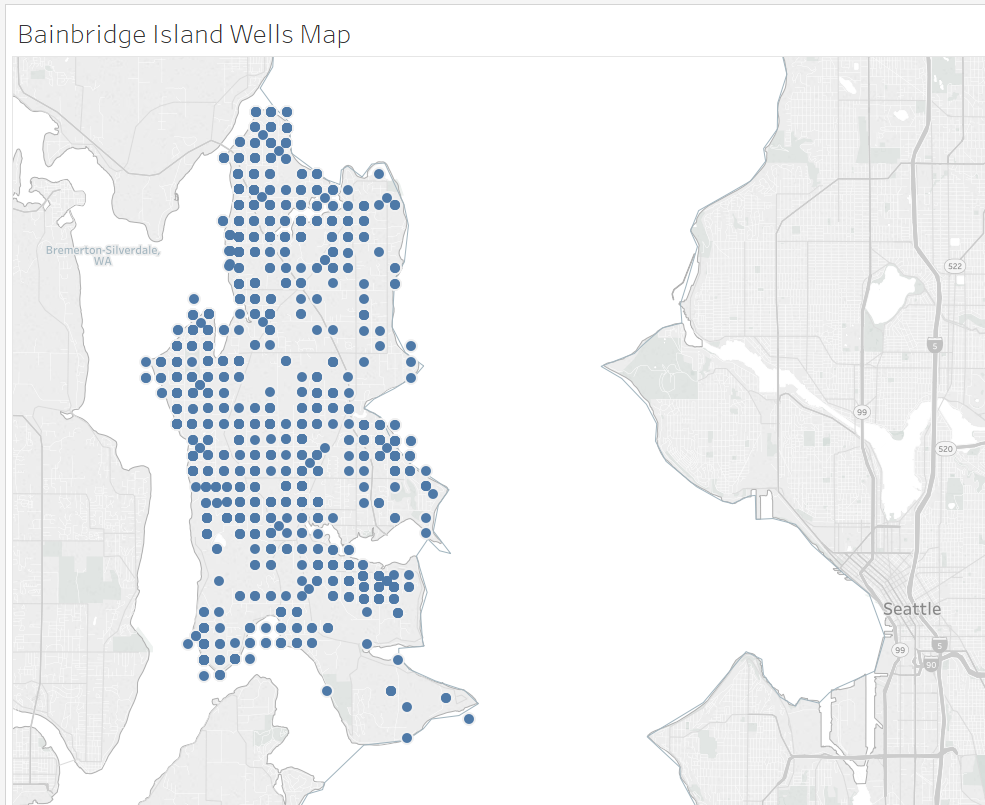

The wells all look properly located on Bainbridge Island. The total well count has now been reduced as shown below

In [29]:
print(str(len(well_logs_data2['well_log_id'])) + ' unique Kitsap County well log IDs')
print(str(bi_wells.shape[0]) + ' unique Bainbridge Island well log IDs')

11338 unique Kitsap County well log IDs
1437 unique Bainbridge Island well log IDs


Next, I need to try and determine the approximate elevation at each well log location, so I can to adjust the depth values to share mean sea level (MSL) as a common reference.

I used the Open-Elevation API (https://open-elevation.com/) to get this information. Unfortunately, the API is currently underfunded and the server does not respond to requests from Python (as noted here: https://github.com/Jorl17/open-elevation/issues/29). I worked around this limitation by breaking the lat-longs into blocs of 100 and pasting the URL directly into the Chrome search box. This returned the JSON response in text form which I them copied into separate txt files which I then read into the workbook.

In [104]:
# Break out the unique lat-lon pairs into 100 block chunks
test = bi_wells.loc[:,['Src Lat', 'Src Lon']].drop_duplicates().reset_index(drop=True)
test1 = test.loc[:99,:]
test2 = test.loc[100:199,:]
test3 = test.loc[200:299,:]
test4 = test.loc[300:,:]

In [110]:
test.shape, test1.shape, test2.shape, test3.shape, test4.shape

((348, 2), (100, 2), (100, 2), (100, 2), (48, 2))

In [111]:
# Generate the URLs to be pasted into the Chrome search bar
blank_url = 'https://api.open-elevation.com/api/v1/lookup?locations={}'
locations1 = '|'.join(str(test1.loc[x,'Src Lat']) + ',' + str(test1.loc[x,'Src Lon']) for x in test1.index)
locations2 = '|'.join(str(test2.loc[x,'Src Lat']) + ',' + str(test2.loc[x,'Src Lon']) for x in test2.index)
locations3 = '|'.join(str(test3.loc[x,'Src Lat']) + ',' + str(test3.loc[x,'Src Lon']) for x in test3.index)
locations4 = '|'.join(str(test4.loc[x,'Src Lat']) + ',' + str(test4.loc[x,'Src Lon']) for x in test4.index)
url1 = blank_url.format(locations1)
url2 = blank_url.format(locations2)
url3 = blank_url.format(locations3)
url4 = blank_url.format(locations4)

In [124]:
# Read in response text files
raw_elevations = pd.DataFrame()
for i in range(1,5):
    with open(r'{}test{}_elevations.txt'.format(outPath,i)) as json_data:
        # Load JSON data
        d = json.load(json_data)
        # Read into data frame
        temp_df = pd.io.json.json_normalize(d['results'])
        # Store in main frame
        raw_elevations = raw_elevations.append(temp_df)

In [129]:
# Convert elevation from meters to feet
raw_elevations.loc[:,'elevation (ft)'] = raw_elevations['elevation']*3.28084

In [130]:
raw_elevations.shape, raw_elevations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 47
Data columns (total 4 columns):
latitude          348 non-null float64
elevation         348 non-null int64
longitude         348 non-null float64
elevation (ft)    348 non-null float64
dtypes: float64(3), int64(1)
memory usage: 13.6 KB


((348, 4), None)

In [132]:
# Add elevation data to BI well data
bi_wells = pd.merge(bi_wells, raw_elevations, how='left', 
                    left_on = ['Src Lat', 'Src Lon'], right_on = ['latitude','longitude'])

In [137]:
bi_wells.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437 entries, 0 to 1436
Data columns (total 14 columns):
Number of Records     1437 non-null int64
St Plane Xcoord Nr    1437 non-null int64
St Plane Ycoord Nr    1437 non-null int64
Src Lat               1437 non-null float64
Src Lon               1437 non-null float64
Well Comp Dt          1437 non-null object
Well Depth Qt         1437 non-null float64
Well Diameter Qt      1426 non-null float64
Well Log Id           1437 non-null int64
Well Type Cd          1437 non-null object
latitude              1437 non-null float64
elevation             1437 non-null int64
longitude             1437 non-null float64
elevation (ft)        1437 non-null float64
dtypes: float64(7), int64(5), object(2)
memory usage: 168.4+ KB


From the above I can confirm that all 1437 bi_wells records have a non-null value for the elevation in feet and meters.

Now, I need to add a column for the adjusted well depth as measured from the mean sea level.

In [138]:
# Add adjusted well depth column off of mean sea level
bi_wells.loc[:,'Well Depth'] = bi_wells['elevation (ft)'] - bi_wells['Well Depth Qt']

With this final field added I can output the file for further exploration in Tableau to determine if any additional filtering is needed.

In [139]:
# Output unfiltered BI wells data
bi_wells.to_csv('{}well_data_bainbridge_island.csv'.format(outPath),header=True,index=False)

First, I removed all records with a well depth of 0 since this value does not make sense. I then had to check all of the wells with an elevation of 0 because the Open-Elevation API returns an elevation of 0 when there is no actual record for the provided lat-lon. Hopefully, I can visually determine if the zero-elevation sites are legitimate.

The map of zero-depth and zero-elevation wells are below

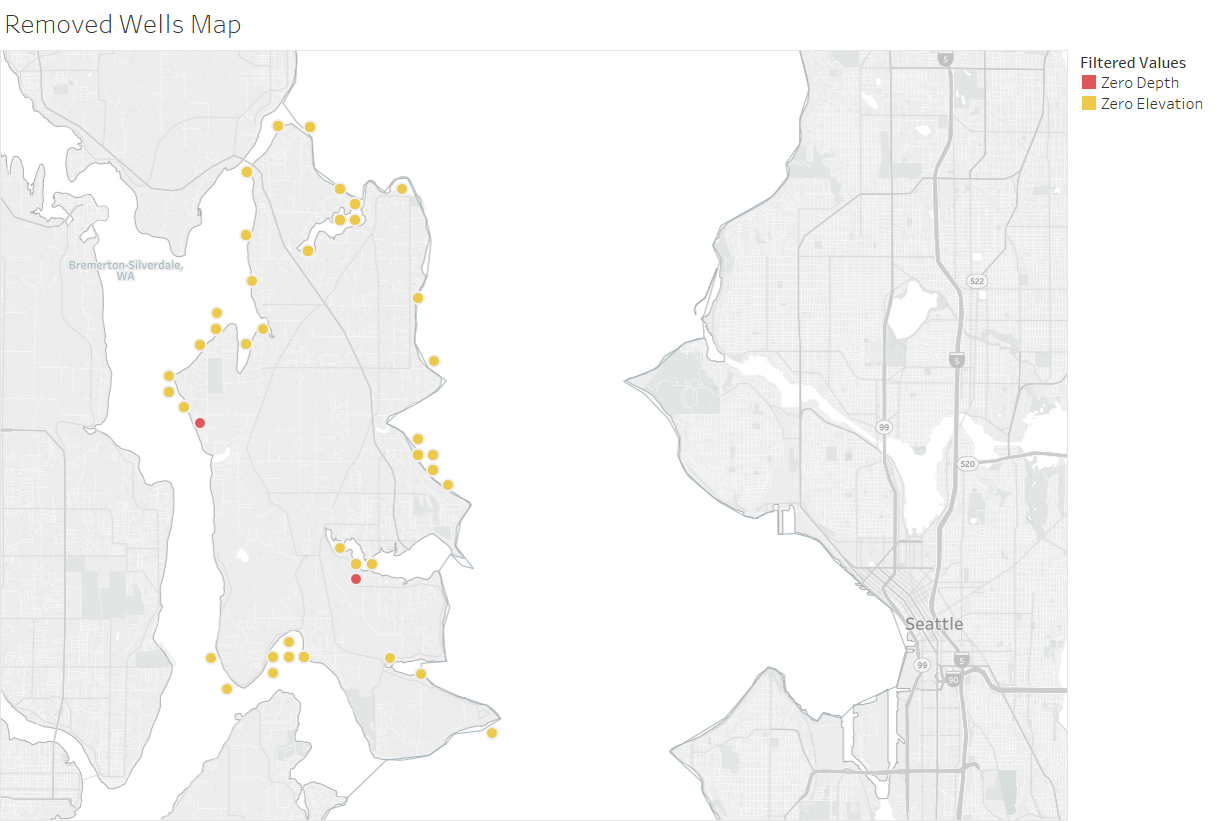

Luckily, there are only two locations with zero well depth and all of the zero-elevation records are, in fact, at an elevation of zero. I will then remove the records with zero well depth and leave the ones with zero elevation.

In [148]:
zero_depth = bi_wells[(bi_wells['elevation (ft)']!=0)&(bi_wells['Well Depth Qt']==0)].shape[0]
total = bi_wells.shape[0]
print('{} records were removed because of zero well depth'.format(zero_depth) + 
      ' ({}% of total record count)'.format(round(zero_depth/total*100,2)))

2 records were removed because of zero well depth (0.14% of total record count)


In [169]:
# Drop records with zero well depth
bi_wells = bi_wells[bi_wells['Well Depth Qt'] != 0]

Next, I investigated the trend of well depths to see if there are any other unusal values by constructing the dashboard shown below. In the left pane I plotted the trend in the number of wells drilled on Bainbridge Island annually and in the right pane I plotted the well depth of each well_id.

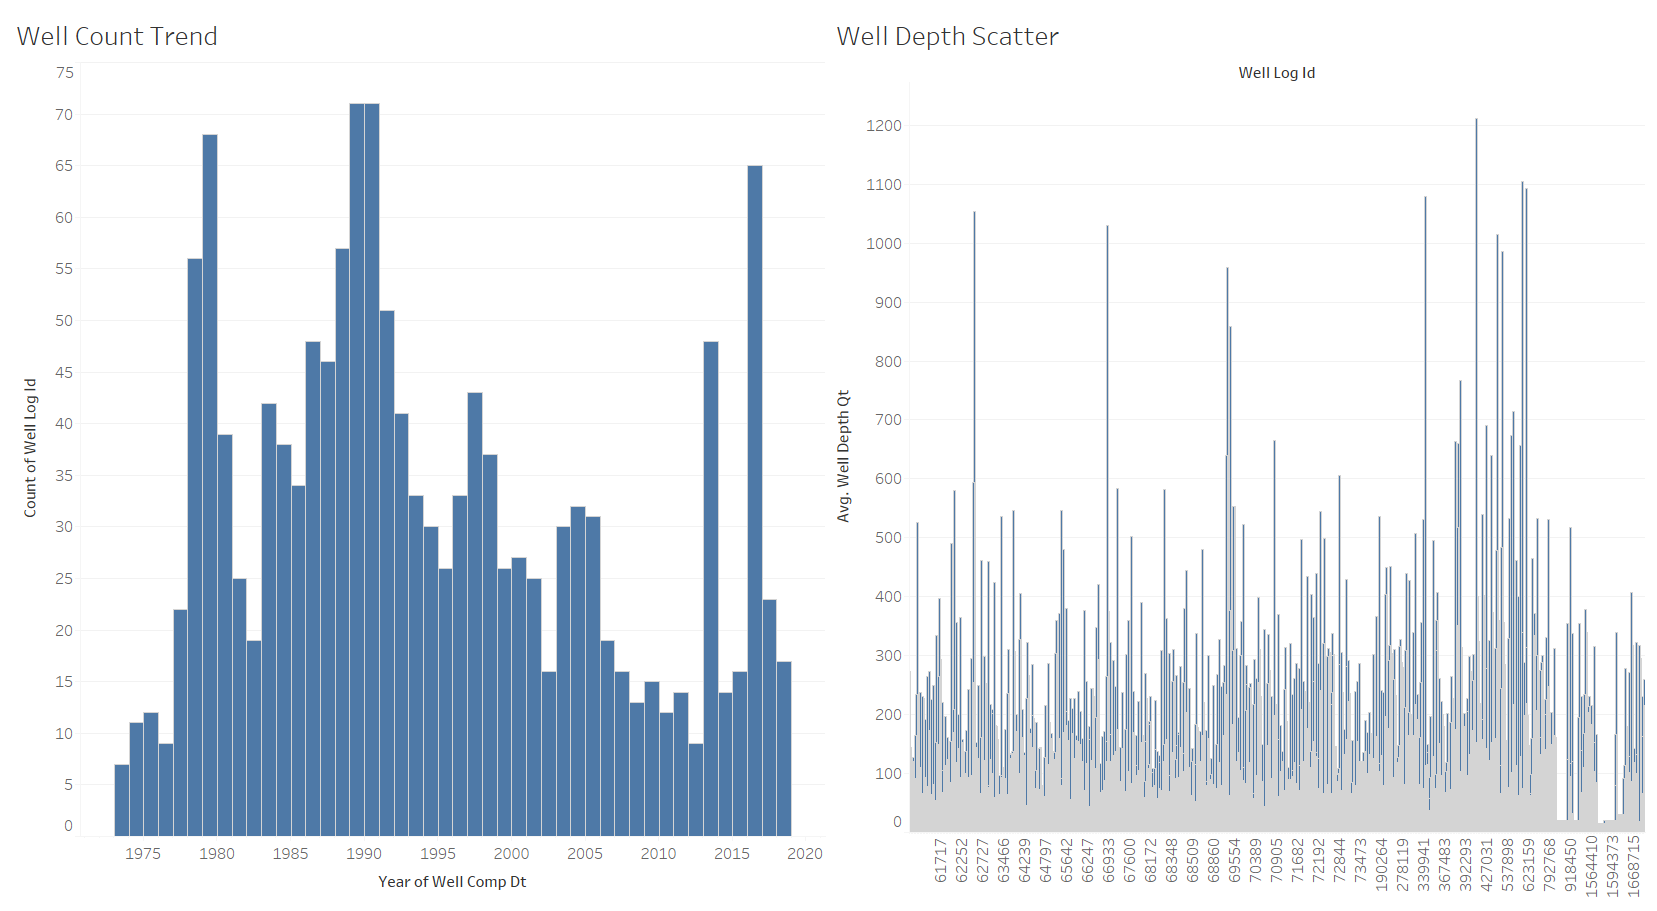

By clicking through any unsual looking years I was able to quickly check for anything that looked off. I started by checking the unusually high spikes of 2013 and 2016. There is definitely something off about the number of wells with consecutive well_log_ids at the exact same depth

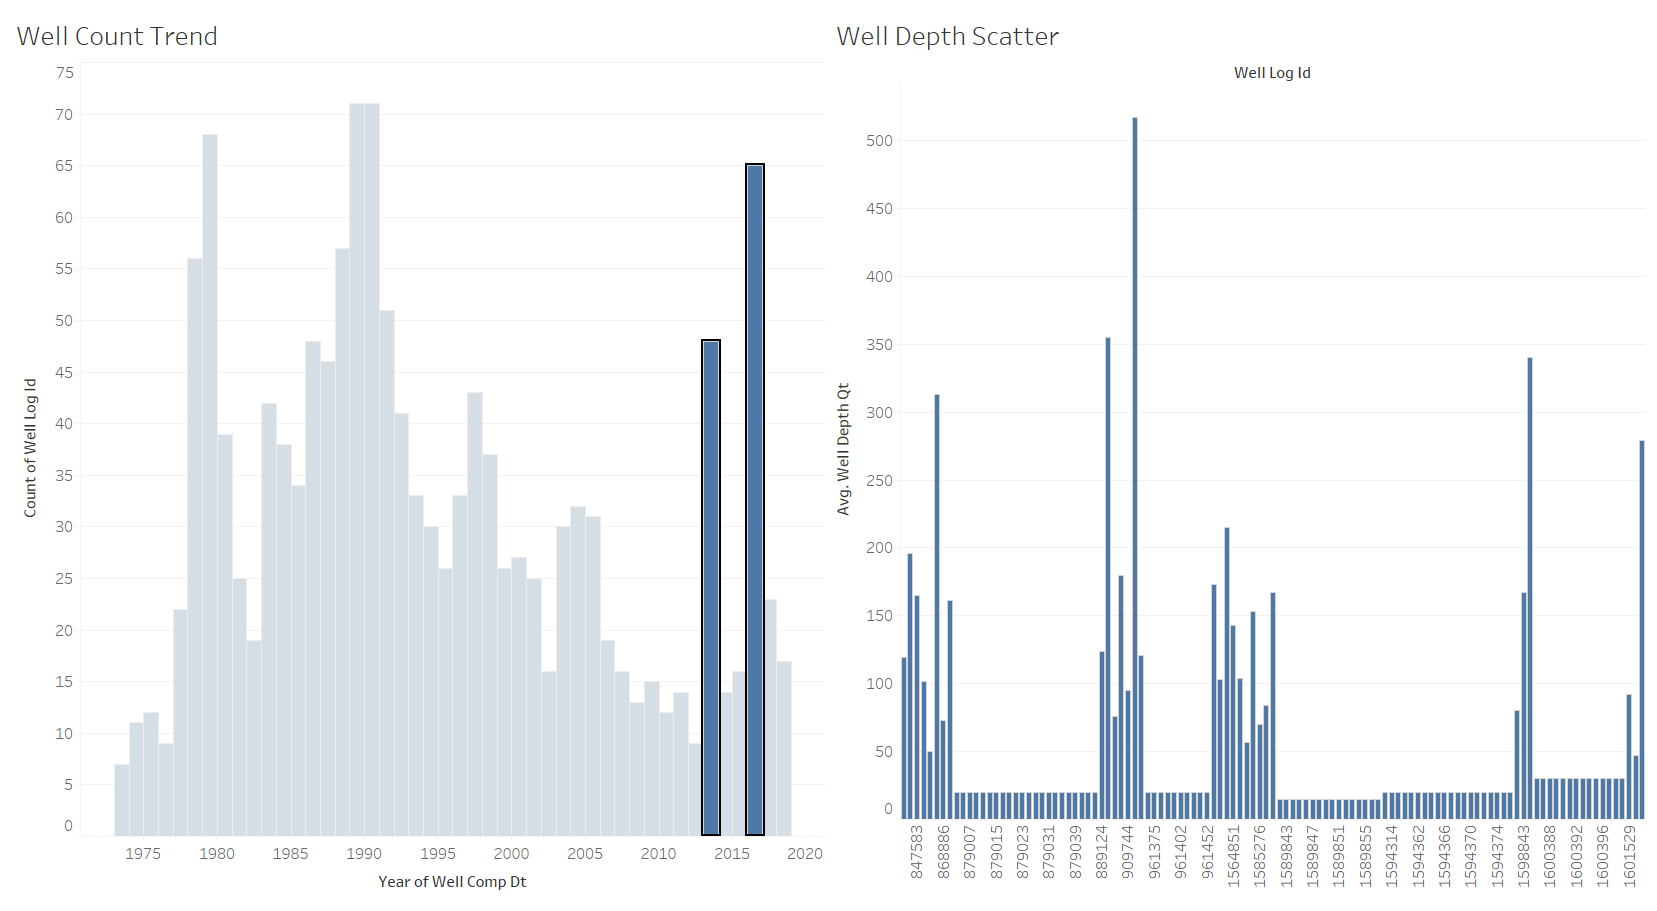

Further exploration revealed that these wells are also in the same location. Even if these wells are all legitimate (which I doubt) they represent an oversampling of that particular location. I will therefore remove wells that were drilled on the same date, in the same location, and to the exact same depth.

In [170]:
# Set Well Comp Dt to datetime format
bi_wells.loc[:,'Well Comp Dt'] = pd.to_datetime(bi_wells['Well Comp Dt'])
# Add in year field
bi_wells.loc[:,'Year'] = bi_wells['Well Comp Dt'].dt.year

In [171]:
# Drop duplicate well records
bi_wells_trim = bi_wells.drop_duplicates(subset=['Well Comp Dt','St Plane Xcoord Nr','St Plane Ycoord Nr','Well Depth Qt'])

In [172]:
bi_wells.shape, bi_wells_trim.shape

((1435, 16), (1353, 16))

In [177]:
# Output final data
keepCols = ['Well Log Id','Well Comp Dt','Year',
            'Well Depth Qt','Well Diameter Qt','Well Depth','elevation','elevation (ft)',
            'St Plane Xcoord Nr','St Plane Ycoord Nr','latitude','longitude']

bi_wells_trim[keepCols].to_csv('{}well_data_bainbridge_island_final.csv'.format(outPath),header=True,index=False)